[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module6_Files/Deep_Recommendations.ipynb)

# Deep Recommendations
-----------------------------------------
**OPIM 5509: Introduction to Deep Learning - University of Connecticut**

This material is largely based off [this excellent blog](https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929) post (which I think is a step above the [Keras documentation for collaborative filtering](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)). Think about how you can extend these methodologies to other things besides movie reviews... like trying predict student success in their major degree programs!

This script will make use of the Functional() API instead of the Sequential() API from Keras. You will be able to follow along easily enough - [read here](https://hanifi.medium.com/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e) for more comparisons.

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Read Data and Basic EDA
Whenever you get a dataset for the first time, make sure you take a minute and try to get understand the inner workings. Here, you will use the movie ratings dataset where you have a column for:
* userID (unique key to identify each person)
* movieID (unique key to indentify each movie)
* rating (the score the user gave to the movie)
* timestamp (when they watched the movie)

We will use Gdown to get the file. You can download the full .zip file locally and unzip it to your Drive if you wish. [Here is the source](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip).

In [ ]:
# # https://drive.google.com/file/d/1awQcb13uqlXNywGbzNG9jK7cYwkPbYfr/view?usp=sharing
# !gdown --id 1awQcb13uqlXNywGbzNG9jK7cYwkPbYfr

Downloading...
From: https://drive.google.com/uc?id=1awQcb13uqlXNywGbzNG9jK7cYwkPbYfr
To: /content/ratings.csv
2.48MB [00:00, 75.1MB/s]


In [4]:
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module6_Files/ratings.csv"

# retrieve the data and build a dataframe
ratings = pd.read_csv(url)

ratings.shape

(100836, 4)

Look left to see the file downloaded to your local workspace, then read the data.

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Note that this data has largely been cleaned up for you - most people and users aren't called `1, 2, 3`... you would need to use `LabelEncoder()` to go from names like `Dave` or `Magnolia` to `1, 2` respectively.

How many movies are these people watching?

In [ ]:
tmp = ratings.groupby('userId')['movieId'].nunique()
tmp = pd.DataFrame(tmp)
tmp

,movieId
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [ ]:
# check your work! number of unique movie users
ratings['userId'].nunique() # 610 movie users!

610

In [ ]:
# check your work! number of unique movies
ratings['movieId'].nunique() # 9724 movies...

9724

Here's what the number of movies per person is.

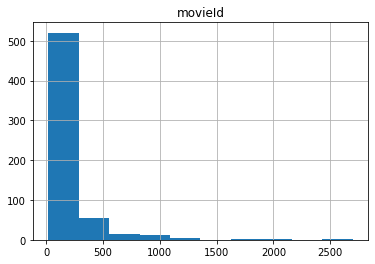

In [ ]:
tmp.hist()
plt.show()

Here are the summary stats on number of movies watched per user.

In [ ]:
# someone really watched >2500 movies... do you have a friend like that?
tmp.describe()

,movieId
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


We also may be interested in the average score per user. I will overwrite my `tmp` variable because I am lazy.

In [ ]:
tmp = ratings.groupby('userId')['rating'].mean()
tmp = pd.DataFrame(tmp)
tmp

,rating
userId,
1,4.366379
2,3.948276
3,2.435897
4,3.555556
5,3.636364
...,...
606,3.657399
607,3.786096
608,3.134176


And here is the distribution of average rating by user.

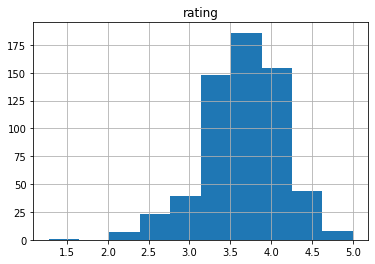

In [ ]:
tmp.hist()
plt.show()

Some people are real grumps! 1.5 as the average rating, but this is rare.

# Using `LabelEncoder()` to prep the data
The data looks pretty clean - but so that you know how to use `LabelEncoder` we will add this section.

In [ ]:
# encode the users
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

# encode the movies
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)

# stats
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

print(n_users, n_movies, min_rating, max_rating)

610 9724 0.5 5.0


# Basic Modeling Idea
You have now learned about embedding layers for words when we covered 'text sequences'. NOW you are going to make embeddings for categories like movies and users.

If you make 3D embedding for each person, and a 3D embedding for each movie... like this...

![dot product](http://media5.datahacker.rs/2020/04/Picture27-768x290.jpg)

..You can take the dot product of these and get a numeric output (a single `[1,1]` value)! In this case, we would have predicted a person might have ranked the movie 38/100... HOW COOL IS THAT?!

But it gets better. If you relate that output to a DENSE LAYER - then you have built a really cool neural network that will try to simulataneously predict the user review AND generate an embedding for each person.

Recall that the embedding we learn is simply a latent representation of the movie or user, respectively. The numbers don't 'mean' anything... they are just numeric constructs! Just like an LSTM cell and word embeddings update at the same time, so do our embedding layers in the deep recommender system.



## What's so special about 'deep recommendations'?
Honestly - not too much! You should be able to get the hang of this pretty quickly.

# Data Splitting
We will use a random 10% holdout for this example.

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape # looks good!

((90752, 2), (10084, 2), (90752,), (10084,))

# Formatting as Arrays
The way we will build the Deep Recommender requires that the USER ID and the MOVIE ID both be fed as separate arrays. They will be pushed together as two entries in a list. Look below.

In [ ]:
n_factors = 8 # to start, we will give everybody a 2D vector
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# 0 is user, 1 is movie - need to use integers because we are slicing arrays

# Model 1: Basic Deep Recommender

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

# the model is going to be a FUNCTION with three inputs
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)

    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)

    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

# declare and inspect the model
model = RecommenderV1(n_users, n_movies, n_factors) # NOTE THE INPUTS! This helps with layer input/output shapes.
model.summary() # later on, it will fit with x_Train_array and x_Test_array

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 8)         4880        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 8)         77792       input_8[0][0]                    
____________________________________________________________________________________________

The way the model was built results in 20,668 trainable parameters. Let's see how it does!

## Fit The Model
We will add early stopping here as a callback and return the best model. Note that this model fits just like any other DL model in Keras - all of the prep has happened about when we defined our `RecommenderNetV1`.

Epoch 1/500
1418/1418 [==============================] - 3s 2ms/step - loss: 13.0556 - val_loss: 7.7753
Epoch 2/500
1418/1418 [==============================] - 3s 2ms/step - loss: 5.9014 - val_loss: 3.1970
Epoch 3/500
1418/1418 [==============================] - 3s 2ms/step - loss: 2.6222 - val_loss: 2.1633
Epoch 4/500
1418/1418 [==============================] - 3s 2ms/step - loss: 1.7316 - val_loss: 1.7330
Epoch 5/500
1418/1418 [==============================] - 3s 2ms/step - loss: 1.3019 - val_loss: 1.5156
Epoch 6/500
1418/1418 [==============================] - 3s 2ms/step - loss: 1.0699 - val_loss: 1.3943
Epoch 7/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.9373 - val_loss: 1.3235
Epoch 8/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.8513 - val_loss: 1.2802
Epoch 9/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.8018 - val_loss: 1.2560
Epoch 10/500
1418/1418 [==============================] - 3s 2ms/step - 

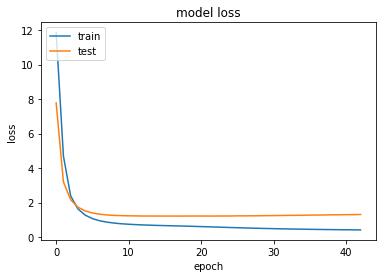

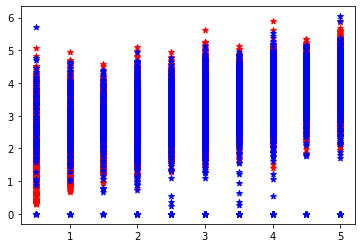

In [ ]:
# early stop!
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,
                           patience=25,
                           restore_best_weights=True)

# fit the model
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=500,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=[early_stop])

# store results
train_preds = model.predict(X_train_array)
test_preds = model.predict(X_test_array)

# score/metrics
train_score = mean_absolute_error(y_train, train_preds)
test_score = mean_absolute_error(y_test, test_preds)

print('Train Score:', train_score)
print('Test Score:', test_score)

# a nice plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# actual vs. pred
# train
plt.scatter(y_train,
          train_preds,
          marker = '*',
          color='red')
plt.scatter(y_test,
          test_preds,
          marker = '*',
          color='blue')
plt.show()



# Model 2: Intermediate Deep Recommender
Now let's add some bias terms (recall how they help our other models converge by adding an extra term or degree of freedom.)

We also will add some cool functionality near the output node... note the use of the `sigmoid` activation function and the scaling that happens afterward to constrain the prediction!

In [ ]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors

    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)

    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 8)         4880        input_9[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 8)         77792       input_10[0][0]                   
____________________________________________________________________________________________

Now we have 31K parameters to train with (when n_factors = 2) - nice!

## Fit The Model
Same code as before! Note that we overwrote `model` above so our code is quite modular.

Epoch 1/500
1418/1418 [==============================] - 4s 2ms/step - loss: 1.4345 - val_loss: 0.9490
Epoch 2/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.8391 - val_loss: 0.7982
Epoch 3/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6950 - val_loss: 0.7667
Epoch 4/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6330 - val_loss: 0.7532
Epoch 5/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6043 - val_loss: 0.7468
Epoch 6/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5673 - val_loss: 0.7456
Epoch 7/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5203 - val_loss: 0.7464
Epoch 8/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.5013 - val_loss: 0.7513
Epoch 9/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.4744 - val_loss: 0.7586
Epoch 10/500
1418/1418 [==============================] - 3s 2ms/step - l

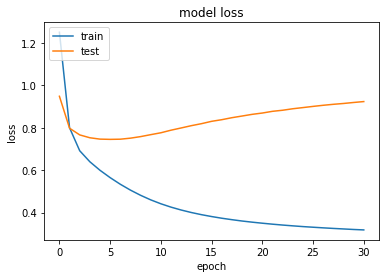

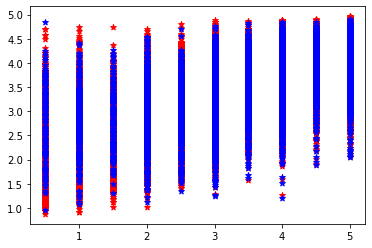

In [ ]:
# early stop!
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,
                           patience=25,
                           restore_best_weights=True)

# fit the model
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=500,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=[early_stop])

# store results
train_preds = model.predict(X_train_array)
test_preds = model.predict(X_test_array)

# score/metrics
train_score = mean_absolute_error(y_train, train_preds)
test_score = mean_absolute_error(y_test, test_preds)

print('Train Score:', train_score)
print('Test Score:', test_score)

# a nice plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# actual vs. pred
# train
plt.scatter(y_train,
          train_preds,
          marker = '*',
          color='red')
plt.scatter(y_test,
          test_preds,
          marker = '*',
          color='blue')
plt.show()

# Model 3: Something totally different!
Let's play with embeddings a little bit. Instead of them being multiplied... what if they both just went into a dense layer?!

In [ ]:
# note that you defined 'EmbeddingLayer' in the second model!

from keras.layers import Concatenate, Dense, Dropout
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)

    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)

    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)

    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 8)         4880        input_11[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 8)         77792       input_12[0][0]                   
____________________________________________________________________________________________

## Fit The Model

Epoch 1/500
1418/1418 [==============================] - 4s 2ms/step - loss: 1.2174 - val_loss: 0.7995
Epoch 2/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.7777 - val_loss: 0.7809
Epoch 3/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.7290 - val_loss: 0.7768
Epoch 4/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6991 - val_loss: 0.7799
Epoch 5/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6942 - val_loss: 0.7828
Epoch 6/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6815 - val_loss: 0.7812
Epoch 7/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6782 - val_loss: 0.7823
Epoch 8/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6769 - val_loss: 0.7821
Epoch 9/500
1418/1418 [==============================] - 3s 2ms/step - loss: 0.6745 - val_loss: 0.7869
Epoch 10/500
1418/1418 [==============================] - 3s 2ms/step - l

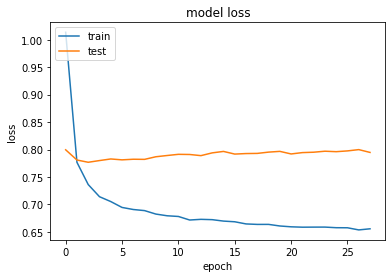

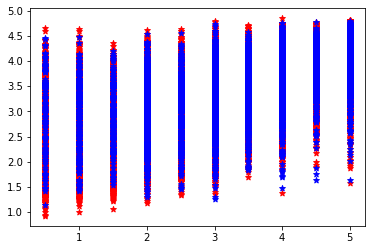

In [ ]:
# early stop!
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,
                           patience=25,
                           restore_best_weights=True)

# fit the model
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=500,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=[early_stop])

# store results
train_preds = model.predict(X_train_array)
test_preds = model.predict(X_test_array)

# score/metrics
train_score = mean_absolute_error(y_train, train_preds)
test_score = mean_absolute_error(y_test, test_preds)

print('Train Score:', train_score)
print('Test Score:', test_score)

# a nice plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# actual vs. pred
# train
plt.scatter(y_train,
          train_preds,
          marker = '*',
          color='red')
plt.scatter(y_test,
          test_preds,
          marker = '*',
          color='blue')
plt.show()

## What's the benefit of ditching the dot product?

Flexibility! Now you can include extra metadata on the movie or the user - you don't have to worry about the dot products lining up because they are going straight into a Dense Layer.

You can consider metadata like what time or day or holiday did they watch the movie? Maybe add some proxy data that describes what's happening in the World... or from THEIR World by scraping data off of a wearable like an APPLE WATCH or by READING YOUR EMAIL (!) about whether or not they are having a good day or bad day?!

Look out World - this (the embedding layer) is the future!

# On Your Own
You can try updating the code in the Keras documentation for what show you should watch next!